- rsi buy and sell signal (few months of data)
- parameter optimization (back testing) (walk forward)(few year of data)
    - (look back period, buy_threshold, sell_threshold)
    - (20, 30, 70) (20, 20, 80) (20, 10, 90), (50, 30, 70) (50, 20, 80) (50, 10, 90)
    - store data in data base and back test, 
    - historical data till yeterday, now for next day, get the data and store in the data base
    

In [1]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import date

In [2]:
from mod_my_utils.read_write_data import *

In [3]:
folder_path = 'data/'
stock_name = 'AAPL'
index_col = 'Date'

In [4]:
stock_data = get_price_csv(folder_name=folder_path,symbol=stock_name, index_col=index_col)

stock name:  AAPL


In [5]:
data = stock_data[["Adj. Close"]].copy()
data.columns = ["price"]
data.head()

,price
Date,
2007-12-03,22.986003
2007-12-04,23.108091
2007-12-05,23.839335
2007-12-06,24.411582
2007-12-07,24.970258


In [6]:
### Strategy

In [7]:
from mod_backtest_utils.backtest import Strategy, Portfolio

In [8]:
# help(Strategy)
help(Portfolio)

Help on class Portfolio in module mod_backtest_utils.backtest:

class Portfolio(builtins.object)
 |  An abstract base class representing a portfolio of positions (including both instruments and cash), 
 |  determined on the basis of a set of signals provided by a Strategy.
 |  
 |  Methods defined here:
 |  
 |  backtest_portfolio(self)
 |      Provides the logic to generate the trading orders and subsequent equity curve (i.e. growth of total equity),
 |      as a sum of holding and cash, and the bar -period returns associated with this curve based on the 
 |      'positions' DataFrame
 |      
 |      Produces a portfolio object that can be examined by other classes/functions.
 |  
 |  generate_positions(self)
 |      Provides the logic to determine how the portfolio positions are allocated on the basis of 
 |      forecasting signals and available cash.
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__

In [9]:
period = 14
buy_threshold = 30
sell_threshold = 70

In [10]:
class RSIStrategy(Strategy):
    """
    Requires:
    symbol: A stock symbol on which to form a strategy
    bars: A DataFrame of bars for the above symbol
    period: Look back period for RSI indicator calculation
    
    """
    
    def __init__(self, symbol, bars, period, buy_threshold, sell_threshold):
        self.symbol = symbol
        self.bars = bars
        self.period = period
        self.buy_threshold = buy_threshold
        self.sell_threshold = sell_threshold
        
    def generate_signals(self):
        """
        Returns the DataFrame of symbols containing the signals to go long, short or hold (1, -1, 0)
        """
        # initialize data frame of signals with the date from price data frame
        signals = pd.DataFrame(index=self.bars.index)
        signals['price'] = self.bars['price']
        
        # create rsi values
        # change
        signals['change'] = signals['price'].diff(periods = 1)
        # gain
        signals['gain'] = signals['change']
        signals.loc[signals['gain'] < 0, ['gain']] = 0.0
        # loss
        signals['loss'] = signals['change']
        signals.loc[signals['loss'] > 0, ['loss']] = 0.0
        signals['loss'] = abs(signals['loss'])
        # average gain
        signals['avg_gain'] = signals['gain'].rolling(window = period).mean()
        # average loss
        signals['avg_loss'] = signals['loss'].rolling(window= period).mean()
        # rs
        signals['rs'] = signals['avg_gain'] / (signals['avg_loss'] + 0.00005)
        # rsi
        signals['rsi'] = 100 - 100 / (1 + signals['rs'])
        
        
        # Create a signal (invested or not invested) 
        # buy signal when rsi values crosses buy_threshold from bottom
        # sell signal when rsi values crosses sell_threshold from top
        signals['buy']= 0.0
        signals['sell']= 0.0
        signals['buy'] = np.where(signals['rsi'] < buy_threshold, -1.0, 0.0)
        signals['sell'] = np.where(signals['rsi'] > sell_threshold, 1.0, 0.0)
        signals['buy'] = signals['buy'].diff()
        signals['sell'] = signals['sell'].diff()
        signals.loc[signals['buy']==-1.0,['buy']]=0 
        signals.loc[signals['sell']== 1.0,['sell']]=0 
        signals['buy_sell'] = signals['buy'] + signals['sell']
        return signals[['price','buy_sell']]

In [11]:
rsi = RSIStrategy(stock_name, data, period, buy_threshold, sell_threshold)

In [12]:
signals = rsi.generate_signals()

In [13]:
from mod_backtest_utils.portfolio import MarketOnPricePortfolio

In [14]:
help(MarketOnPricePortfolio)

Help on class MarketOnPricePortfolio in module mod_backtest_utils.portfolio:

class MarketOnPricePortfolio(mod_backtest_utils.backtest.Portfolio)
 |  MarketOnPricePortfolio(symbol, signals, initial_capital=100000.0)
 |  
 |  Inherits Portfolio to create a system that purchases 100 units of a particular symbol upon a long/short signals, 
 |  assuming the market open price of a bar.
 |  Encapsulates the notion of a portfolio of positions based on a set of signals as provided by a Strategy
 |  
 |  In addition, there are zero transaction costs and cash can be immediately borrowed for shorting (no margin posting or interest
 |  requirements).
 |  
 |  Requires:
 |  symbol - A stock symbol which forms the basis of the portfolio.
 |  signals - A pandas DataFrame of signals (1, 0, -1) or each symbol.
 |  Initial_capital - the amount in cash at the start of the portfolio.
 |  
 |  Method resolution order:
 |      MarketOnPricePortfolio
 |      mod_backtest_utils.backtest.Portfolio
 |      buil

In [15]:
portfolio = MarketOnPricePortfolio(stock_name, signals=signals)

In [16]:
rsi_portfolio = portfolio.backtest_portfolio()

In [17]:
rsi_portfolio.columns

Index(['holdings', 'cash', 'total'], dtype='object')

def plot_stock_portfolio(portfolio):
    """
    Plot portfolio developed using buy and sell signal
    """
    fig = plt.figure(figsize=(20,20))
    ax1 = fig.add_subplot(411)
    portfolio['holdings'].plot(ax=ax1, title = "Stock Holiding Value")
    ax2 = fig.add_subplot(412)
    portfolio['cash'].plot(ax=ax2, title = "Cash")
    ax3 = fig.add_subplot(413)
    portfolio['total'].plot(ax=ax3, title = "Total")
    plt.show()

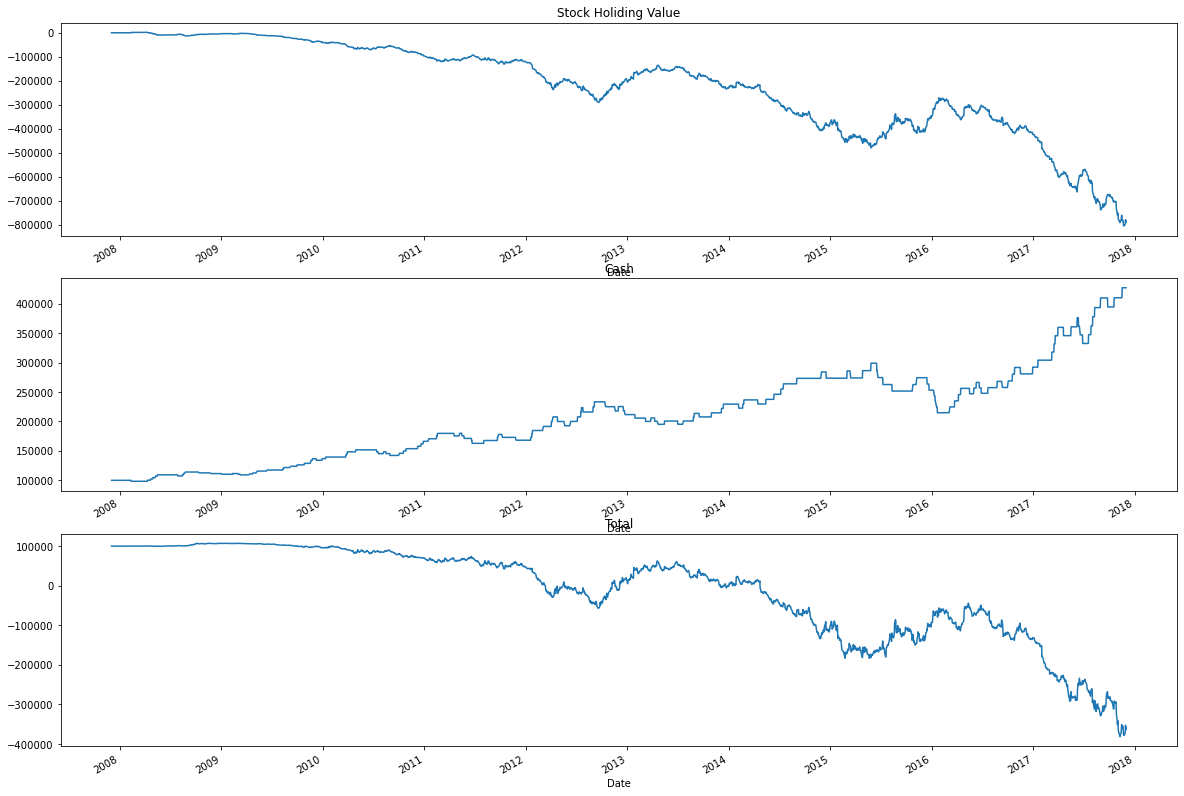

In [18]:
portfolio.plot_stock_portfolio()

In [19]:
AAPL
40

MSFT
60

ADBE
120


NameError: name 'AAPL' is not defined